In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
from zipfile import ZipFile
import os

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

In [2]:
base_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/'

# possible datasets
datasets = ['F-F_Research_Data_Factors_CSV.zip',
            '30_Industry_Portfolios_CSV.zip']

# first we download the data, then we read it, then we delete the folders
for dataset in tqdm(datasets):
    # download the data
    url = base_url + dataset
    r = requests.get(url, allow_redirects=True)
    open(dataset, 'wb').write(r.content)
    # read the data
    with ZipFile(dataset, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall()

100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


In [11]:
with open('30_Industry_Portfolios.CSV') as f:
    for i, line in enumerate(f):
        if line.startswith(','):
            start_ = i
            break
    for j, line in enumerate(f):
        if line == '\n' and j > start_:
            end_ = j
            break

# read the data from start_ to end_
ind_df = pd.read_csv('30_Industry_Portfolios.CSV', skiprows=start_, nrows=end_-start_)
# rename the first column to date and make it the index
ind_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# the year is the first four digits month the last two, make a date
ind_df['date'] = pd.to_datetime(ind_df['date'].astype(str).str[:4] + '-' + ind_df['date'].astype(str).str[-2:])
# move each date to the last day of the month
ind_df['date'] = ind_df['date'] + pd.offsets.MonthEnd(0)

# make date the index
ind_df.set_index('date', inplace=True)

# we dont need the data anymore, so we delete the folder
os.remove('30_Industry_Portfolios.CSV')
os.remove('30_Industry_Portfolios_CSV.zip')

In [12]:
with open('F-F_Research_Data_Factors.CSV') as f:
    for i, line in enumerate(f):
        if line.startswith(','):
            start_ = i
            break
    for j, line in enumerate(f):
        if line == '\n' and j > start_:
            end_ = j
            break

# read the data from start_ to end_
ff_df = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=start_, nrows=end_-start_)
# rename the first column to date and make it the index
ff_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# the year is the first four digits month the last two, make a date
ff_df['date'] = pd.to_datetime(ff_df['date'].astype(str).str[:4] + '-' + ff_df['date'].astype(str).str[-2:])
# move each date to the last day of the month
ff_df['date'] = ff_df['date'] + pd.offsets.MonthEnd(0)

# make date the index
ff_df.set_index('date', inplace=True)

# we dont need the data anymore, so we delete the folder
os.remove('F-F_Research_Data_Factors.CSV')
os.remove('F-F_Research_Data_Factors_CSV.zip')

In [13]:
# keep only the Mkt-RF and RFcolumn
ff_df = ff_df[['Mkt-RF', 'RF']]

In [14]:
# merge the two dataframes on the index
df = ind_df.merge(ff_df, left_index=True, right_index=True)

In [15]:
df.replace(-99.99, np.nan, inplace=True)
df.replace(-999, np.nan, inplace=True)

# make all returns by dividing by 100
df = df/100

In [16]:

betas = np.zeros(len(df.columns))
var_market = np.var(df['Mkt-RF'])
for i, ind in tqdm(enumerate(df.columns)):
    # compute betas
    betas[i] = np.cov(df[ind], df['Mkt-RF'])[0,1]/var_market

# make betas a series with the column names as index
betas = pd.Series(betas, index=df.columns)

# compute the sample mean of returns
# we annualize
mean_returns = df.mean()*100*12

# compute the implied expected returns by the CAPM
capm_returns = np.zeros(len(df.columns))
for i, ind in tqdm(enumerate(df.columns)):
    # compute the implied expected returns by the CAPM
    capm_returns[i] = mean_returns['RF'] + betas[i]*(mean_returns['Mkt-RF'] - mean_returns['RF'])

# make capm_returns a series with the column names as index
capm_returns = pd.Series(capm_returns, index=df.columns)

32it [00:00, 1819.28it/s]
32it [00:00, 18933.24it/s]


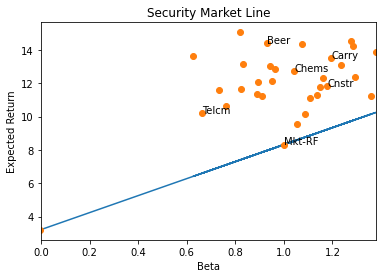

In [17]:
# plot the security market line and label axis
plt.plot(betas, capm_returns, '-')
plt.plot(betas, mean_returns, 'o')
# x axist starts at 0
plt.xlim(0, max(betas))
# label the Mkt-RF point and 5 random other points
plt.text(betas['Mkt-RF'], mean_returns['Mkt-RF'], 'Mkt-RF')
for i in np.random.randint(1, len(df.columns), 5):
    plt.text(betas[i], mean_returns[i], df.columns[i])
plt.xlabel('Beta')
plt.ylabel('Expected Return')
plt.title('Security Market Line')
plt.show()

In [18]:

w = 60 # window size
# we create a dataframe with the betas
betas_df = pd.DataFrame(index=df.index, columns=df.columns)
sd_df = pd.DataFrame(index=df.index, columns=df.columns)
# compute beta using data from t-w-1 to t-1 assign this beta to t
# dont use the var_market computed before, as it is not a rolling window
for t in tqdm(range(w, len(df))):
    # compute the betas for each industry
    for i, ind in enumerate(df.columns):
        # compute betas
        betas_df.iloc[t, i] = np.cov(df.iloc[t-w:t, i], df.iloc[t-w:t, -2])[0,1]/np.var(df.iloc[t-w:t, -2])
        # compute the standard error of returns
        sd_df.iloc[t,i] = np.std(df.iloc[t-w:t, i] - betas_df.iloc[t, i]*df.iloc[t-w:t, -2])
        

100%|██████████| 1086/1086 [01:11<00:00, 15.21it/s]


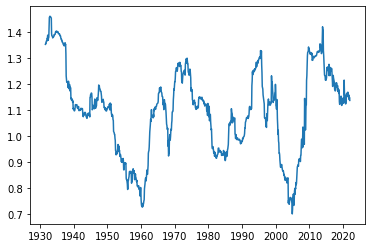

In [19]:
# plot the betas for the finance industry
plt.plot(betas_df['Fin  '])

In [20]:
# we now do a series of cross sectional regressions
# of the model 
# r = gamma_0 + gamma_1 beta + gamma_2 beta^2 + gamma_3 std
# we use the betas and standard deviations computed above

gamma_0 = np.zeros(len(df))
gamma_1 = np.zeros(len(df))
gamma_2 = np.zeros(len(df))
gamma_3 = np.zeros(len(df))

for t in tqdm(range(w, len(df))):

    X = np.vstack([betas_df.iloc[t], betas_df.iloc[t]**2, sd_df.iloc[t]]).T
    y = df.iloc[t].values
    # convert X to float, makes missing values NaNs
    X = X.astype(float)
    # we use the OLS function from statsmodels
    # we use the constant term
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    # obtain the coefficients
    gamma_0[t] = results.params[0]
    gamma_1[t] = results.params[1]
    gamma_2[t] = results.params[2]
    gamma_3[t] = results.params[3]

# do a t test to see if gamma_0 equals mean_returns['RF']
# we use the t test from statsmodels

t_0 = (gamma_0[w:].mean() - mean_returns['RF'])/(gamma_0[w:].std()/np.sqrt(len(gamma_0[w:])))
t_1 = (gamma_1[w:].mean()- mean_returns['Mkt-RF'])/(gamma_1[w:].std()/np.sqrt(len(gamma_1[w:])))
# t_2 and t_3 have zero on the RHS
t_2 = gamma_2[w:].mean()/(gamma_2[w:].std()/np.sqrt(len(gamma_2[w:])))
t_3 = gamma_3[w:].mean()/(gamma_3[w:].std()/np.sqrt(len(gamma_3[w:])))
    


100%|██████████| 1086/1086 [00:02<00:00, 439.85it/s]


In [21]:
# do a t test to see if gamma_0 equals mean_returns['RF']
# we use the t test from statsmodels

t_0 = (gamma_0[w:].mean() - mean_returns['RF'])/(gamma_0[w:].std()/np.sqrt(len(gamma_0[w:])))
t_1 = (gamma_1[w:].mean()- mean_returns['Mkt-RF'])/(gamma_1[w:].std()/np.sqrt(len(gamma_1[w:])))
# t_2 and t_3 have zero on the RHS
t_2 = gamma_2[w:].mean()/(gamma_2[w:].std()/np.sqrt(len(gamma_2[w:])))
t_3 = gamma_3[w:].mean()/(gamma_3[w:].std()/np.sqrt(len(gamma_3[w:])))
    


In [22]:
import scipy.stats as stats
# compute the p-value of each t test and print the test results
p_0 = 2*(1 - stats.t.cdf(abs(t_0), len(gamma_0[w:])))
p_1 = 2*(1 - stats.t.cdf(abs(t_1), len(gamma_1[w:])))
p_2 = 2*(1 - stats.t.cdf(abs(t_2), len(gamma_2[w:])))
p_3 = 2*(1 - stats.t.cdf(abs(t_3), len(gamma_3[w:])))
# print and round to 2 decimals
print('t_0 = {:.2f}, p_0 = {:.2f}'.format(t_0, p_0))
print('t_1 = {:.2f}, p_1 = {:.2f}'.format(t_1, p_1))
print('t_2 = {:.2f}, p_2 = {:.2f}'.format(t_2, p_2))
print('t_3 = {:.2f}, p_3 = {:.2f}'.format(t_3, p_3))

t_0 = -5627.92, p_0 = 0.00
t_1 = -3098.74, p_1 = 0.00
t_2 = -3.51, p_2 = 0.00
t_3 = 2.27, p_3 = 0.02


In [ ]:
# estimate the alphas of the 30 portfolios with respect to the CAPM
alphas = np.zeros(len(df.columns))
# empty matrix to store the residuals
residuals = np.zeros((len(df), len(df.columns)))
for i, ind in enumerate(df.columns):
    alphas[i] = (df.loc[:, ind]-df.loc[:, 'RF']).mean() - betas[ind]*df.loc[:, 'Mkt-RF'].mean()
    residuals[:, i] = (df.loc[:, ind]-df.loc[:, 'RF']) - betas[ind]*df.loc[:, 'Mkt-RF']

# %%
# Covariance matrix of all portfolios
Sigma = residuals.cov()

# create GRS test
T = len(df)
N = len(df.columns) # note that we add 2 extra assets to the test
# sharpe ratio of the market
sharpe_mkt = (df.loc[:, 'Mkt-RF'].mean())/df.loc[:, 'Mkt-RF'].std()

# compute the GRS statistic, the F test
grs = (T*(T-N-1)/((T-2)*N))*alphas.T @ np.linalg.inv(Sigma) @ alphas /(1+sharpe_mkt**2)

# the grs follows a F with N, T-N-1 degrees of freedome
# compute the p-value
p_grs = 1 - stats.f.cdf(grs, N, T-N-1)